# Regression Project



In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.api import abline_plot
from scipy import stats
from statsmodels import graphics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error



In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/My Drive

/content/drive/My Drive


In [4]:
# importing data
# upload data or mount drive
df = pd.read_csv('updated_data.csv') 

# New Section

<Axes: >

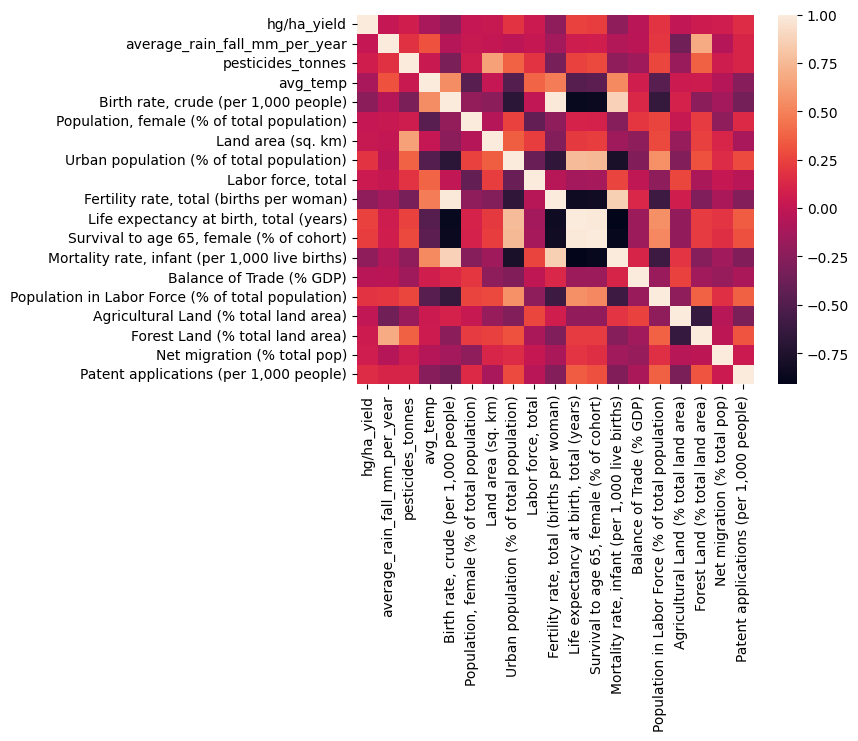

In [5]:
# !ls
# import os
# os.getcwd()
# os.setwd('')
# df.columns
corr_matrix = df.drop(['Area', 'Item', 'Year'], axis=1).corr()
sns.heatmap(corr_matrix)

## Defining Helper Functions

In [6]:
df['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013])

In [7]:
def data_split(df):
    # will have to remove 'Sudan' from test and val as it is not in train
    df = df[df['Area'] != 'Sudan']
    train_data = df[df['Year']<= 2010]
    val_data = df[(df['Year'] >= 2011) & (df['Year']<= 2012)]
    test_data = df[df['Year'] == 2013]
    return train_data, val_data, test_data

In [8]:
def add_onehot(df,column):
    df_new = df.copy()
    one_hot = pd.get_dummies(df_new[column])
    df_new = df_new.drop(column,axis = 1)
    df_new = df_new.join(one_hot)
    return df_new

In [9]:
class MLR():
    def __init__(self,df,significance):
        self.X = df.drop('hg/ha_yield', axis=1)
        self.y = df['hg/ha_yield']
        self.X = sm.add_constant(self.X)
        self.model = sm.OLS(self.y, self.X).fit()
        self.significance = significance
    def modelsummary(self):
        return(self.model.summary())
    def rsquared(self):
        return self.model.rsquared
    def VIF(self):
        vif = [variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])]
        vif = np.array(vif)
        vif = np.sort(vif)
        self.vif_vals = vif
    def cook(self):
        influence = self.model.get_influence()
        cooks_d, pvals = influence.cooks_distance
        self.cooks_dist = cooks_d, pvals
    def DW(self):
        durbin_watson = sm.stats.stattools.durbin_watson(self.model.resid)
        return(durbin_watson)
    def printall(self):
        print(r"""
__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        """)
        print(self.modelsummary())
        print(r"""  
__________________________________________________________________________   
  __  __           _      _                        _           _       _ 
 |  \/  |         | |    | |     /\               | |         (_)     | |
 | \  / | ___   __| | ___| |    /  \   _ __   __ _| |_   _ ___ _ ___  | |
 | |\/| |/ _ \ / _` |/ _ \ |   / /\ \ | '_ \ / _` | | | | / __| / __| | |
 | |  | | (_) | (_| |  __/ |  / ____ \| | | | (_| | | |_| \__ \ \__ \ |_|
 |_|  |_|\___/ \__,_|\___|_| /_/    \_\_| |_|\__,_|_|\__, |___/_|___/ (_)
                                                      __/ |              
                                                     |___/               
__________________________________________________________________________   
""")
        # R-squared
        rsq = self.rsquared()
        print("R Squared value: ", rsq)
        print("__________")
        # VIF
        if not hasattr(full_reg, 'vif'):
          self.VIF()
        
        vif = self.vif_vals
        vif = vif[::-1]
        vif = vif[0:5]
        print("Highest 5 VIF Values: ", vif)
        if vif[0] > max(10,1/(1-rsq)):
            print("Since VIF is too high, multicollinearity is problematic.")
        else:
            print("VIF is not too high, multicollinearity is not problematic.")
        print("__________")
        # COOK
        
        if not hasattr(full_reg, 'cooks_dist'):
          self.cook()
        
        cook,pval = self.cooks_dist
        # print(cook)
        cook = np.sort(cook)
        cook = cook[::-1]
        cook = cook[0:5]
        print("Highest 5 Cook's Distances: ", cook)
        if cook[0] > 4/self.X.shape[0] or cook[0] > 1:
            print("Some Cook's Distances may be a bit high and should be investigated.")
        else:
            print("Cook's Distances are not an issue.")

        print("__________")
        # DW
        lower_bound = 1.53
        upper_bound = 1.47
        durbin_watson_statistic = self.DW()

        # Print the Durbin-Watson test statistic and critical values
        print(f"Durbin-Watson test statistic: {durbin_watson_statistic}")
        print(f"Lower bound: {lower_bound}")
        print(f"Upper bound: {upper_bound}")
        if durbin_watson_statistic > lower_bound and durbin_watson_statistic < upper_bound:
            print("Model passes the Durbin-Watson test (no autocorrelation)")
        else:
            print("Model fails the Durbin-Watson test (autocorrelation detected)")

## Linear Regression on the full set of data

In [10]:
train_data, val_data, test_data = data_split(df)
frtrain_data = add_onehot(train_data,"Area")
frtrain_data = add_onehot(frtrain_data,"Item")
full_reg = MLR(frtrain_data,0.05)
full_reg.printall()


__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        
                            OLS Regression Results                            
Dep. Variable:            hg/ha_yield   R-squared:                       0.758
Model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Highest 5 VIF Values:  [inf inf inf inf inf]
Since VIF is too high, multicollinearity is problematic.
__________
Highest 5 Cook's Distances:  [0.00659183 0.00636564 0.00546848 0.00457081 0.0043098 ]
Some Cook's Distances may be a bit high and should be investigated.
__________
Durbin-Watson test statistic: 1.2055532726737825
Lower bound: 1.53
Upper bound: 1.47
Model fails the Durbin-Watson test (autocorrelation detected)


In [11]:
# outlier analysis
# 'cooks' in full_reg 
# hasattr(full_reg, 'cooks_dist')
cook,pval = full_reg.cooks_dist

#plot horizontal bars using seaborn
#sns.barplot(x=cook, y=np.arange(len(cook)), orient='h')
#plt.show()
len(cook[cook > 4/full_reg.X.shape[0]]) # 1413 outliers (might need to see which ones are bad) 

1413

In [12]:
# Finding insignificant vars
full_reg.model.pvalues[full_reg.model.pvalues > 0.05]

avg_temp                                             0.961060
Birth rate, crude (per 1,000 people)                 0.178200
Population, female (% of total population)           0.240249
Urban population (% of total population)             0.671735
Labor force, total                                   0.206858
Fertility rate, total (births per woman)             0.113700
Life expectancy at birth, total (years)              0.545897
Survival to age 65, female (% of cohort)             0.960766
Mortality rate, infant (per 1,000 live births)       0.629907
Balance of Trade (% GDP)                             0.921059
Population in Labor Force (% of total population)    0.158415
Agricultural Land (% total land area)                0.056982
Net migration (% total pop)                          0.758409
Armenia                                              0.108379
Azerbaijan                                           0.190435
Bahrain                                              0.081320
Belarus 

In [13]:
significant_coef = full_reg.model.params.index[full_reg.model.pvalues < 0.05]

In [14]:
significant_coef

Index(['const', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes',
       'Land area (sq. km)', 'Forest Land (% total land area)',
       'Patent applications (per 1,000 people)', 'Albania', 'Algeria',
       'Angola', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brazil', 'Canada', 'Central African Republic', 'Croatia', 'Denmark',
       'El Salvador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras',
       'India', 'Indonesia', 'Ireland', 'Italy', 'Jamaica', 'Kazakhstan',
       'Lebanon', 'Libya', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania',
       'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Peru',
       'Qatar', 'Saudi Arabia', 'Slovenia', 'South Africa', 'Sri Lanka',
       'Suriname', 'Sweden', 'Switzerland', 'Tajikistan', 'United Kingdom',
       'Uruguay', 'Zambia', 'Cassava', 'Maize', 'Plantains and others',
       'Potatoes', 'Rice, padd

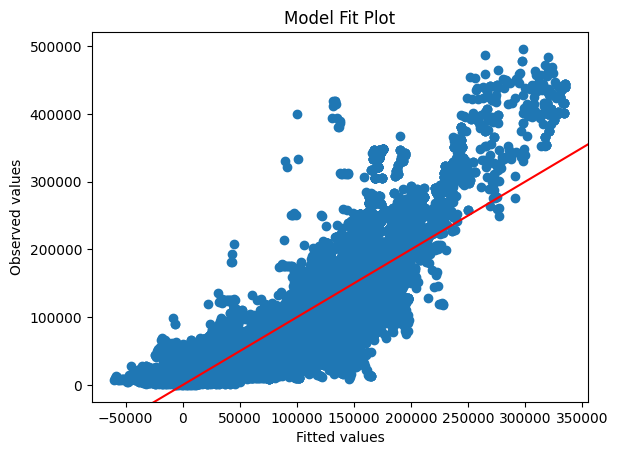

In [15]:
yhat = full_reg.model.fittedvalues

fig, ax = plt.subplots()
ax.scatter(yhat, full_reg.y)
line_fit = sm.OLS(full_reg.y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax, color = 'r')


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

Text(0.5, 0, 'Fitted values')

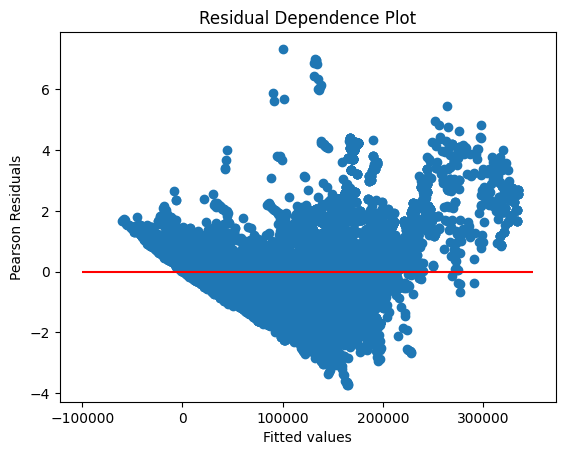

In [16]:

fig, ax = plt.subplots()

ax.scatter(yhat, full_reg.model.resid_pearson)
ax.hlines(0, -100000, 350000, colors='r')
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

Text(0.5, 0, 'Avg rainfall')

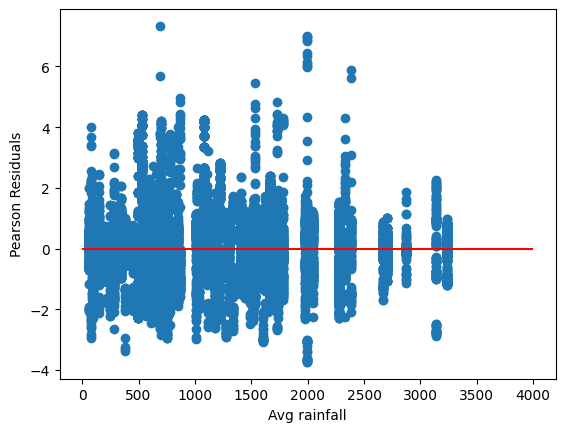

In [17]:
fig, ax = plt.subplots()

ax.scatter(full_reg.X['average_rain_fall_mm_per_year'], full_reg.model.resid_pearson)
ax.hlines(0, 0, 4000, colors='r')
#ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Avg rainfall')

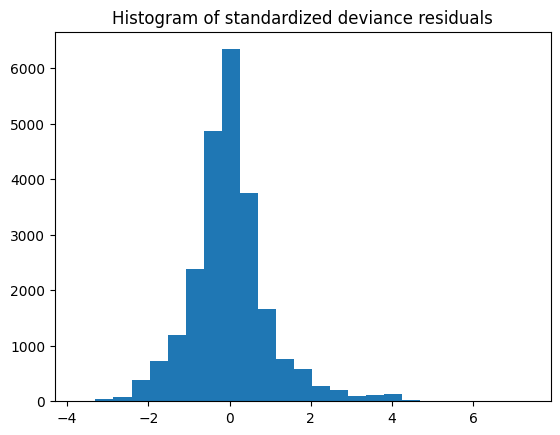

In [18]:
fig, ax = plt.subplots()

resid = full_reg.model.resid_pearson.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

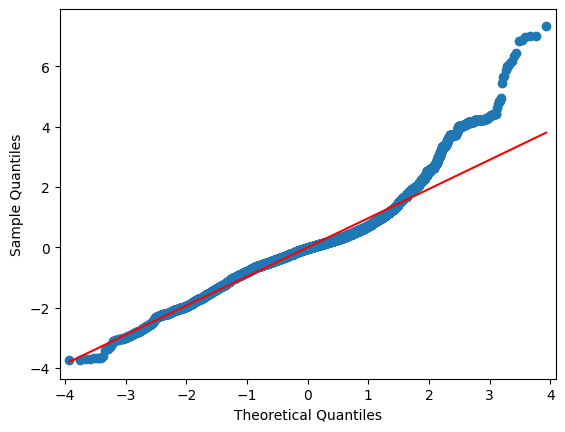

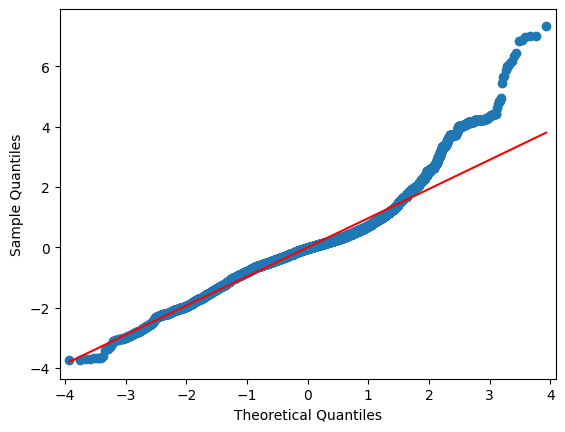

In [19]:
# qq plots
graphics.gofplots.qqplot(resid, line='r')

In [20]:
def model_rmse(model, test_data):
  frtest_data = add_onehot(test_data,"Area")
  frtest_data = add_onehot(frtest_data,"Item")
  y_test = frtest_data['hg/ha_yield']
  frtest_data = frtest_data.drop('hg/ha_yield', axis=1)
  frtest_data = sm.add_constant(frtest_data, has_constant='add')

  y_pred = model.predict(frtest_data)

  #evaluate RMSE
  qwe = rmse(y_test, y_pred)

  #evaluate MAPE
  qwe2 = mean_absolute_percentage_error(y_test, y_pred)
  
  return qwe, qwe2



# model_rmse(full_reg.model, test_data)
model_rmse(full_reg.model, val_data)

(50866.34416653119, 0.8312926328370773)

In [21]:
print(df.columns)

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp', 'Birth rate, crude (per 1,000 people)',
       'Population, female (% of total population)', 'Land area (sq. km)',
       'Urban population (% of total population)', 'Labor force, total',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Survival to age 65, female (% of cohort)',
       'Mortality rate, infant (per 1,000 live births)',
       'Balance of Trade (% GDP)',
       'Population in Labor Force (% of total population)',
       'Agricultural Land (% total land area)',
       'Forest Land (% total land area)', 'Net migration (% total pop)',
       'Patent applications (per 1,000 people)'],
      dtype='object')


In [22]:
selected_vars = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes',
       'Land area (sq. km)', 'Forest Land (% total land area)',
       'Patent applications (per 1,000 people)', 'Albania', 'Algeria',
       'Angola', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brazil', 'Canada', 'Central African Republic', 'Croatia', 'Denmark',
       'El Salvador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras',
       'India', 'Indonesia', 'Ireland', 'Italy', 'Jamaica', 'Kazakhstan',
       'Lebanon', 'Libya', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania',
       'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Peru',
       'Qatar', 'Saudi Arabia', 'Slovenia', 'South Africa', 'Sri Lanka',
       'Suriname', 'Sweden', 'Switzerland', 'Tajikistan', 'United Kingdom',
       'Uruguay', 'Zambia', 'Cassava', 'Maize', 'Plantains and others',
       'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Sweet potatoes',
       'Wheat', 'Yams']

reduced_X = frtrain_data[selected_vars]

In [23]:
full_reg.X.shape

(23608, 127)

In [24]:
reduced_X.shape

(23608, 71)

In [25]:
full_reg.y.shape

(23608,)

In [26]:
model1 = sm.OLS(full_reg.y, reduced_X).fit() # reduced regression model

# model_rmse(model1, test_data)
#model_rmse(model1, val_data)

In [27]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hg/ha_yield   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     998.7
Date:                Fri, 28 Apr 2023   Prob (F-statistic):               0.00
Time:                        04:53:47   Log-Likelihood:            -2.8455e+05
No. Observations:               23608   AIC:                         5.692e+05
Df Residuals:                   23537   BIC:                         5.698e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Year                                    1033.5211     45.327     22.801      0.000     944.677    1122.366
average_rain_fall_mm_per_year            -23.3414      0.954    -24.472      0.000     -25.211     -21.472
pesticides_tonnes                          0.0549      0.009      5.777      0.000       0.036       0.073
Land area (sq. km)                         0.0523      0.002     24.057      0.000       0.048       0.057
Forest Land (% total land area)          383.0555     36.185     10.586      0.000     312.130     453.981
Patent applications (per 1,000 people)  2.459e+04    741.195     33.176      0.000    2.31e+04     2.6e+04
Albania                                 3.887e+04   4576.054      8.494      0.000    2.99e+04    4.78e+04
Algeria                                -1.073e+05   6413.862    -16.725      0.000    -1.2e+05   -9.47e+04
Angola                                 -8.908e+04   4323.933    -20.602      0.000   -9.76e+04   -8.06e+04
Argentina                              -9.902e+04   5863.711    -16.887      0.000   -1.11e+05   -8.75e+04
Australia                              -3.276e+05   1.62e+04    -20.219      0.000   -3.59e+05   -2.96e+05
Austria                                 7.165e+04   4706.007     15.225      0.000    6.24e+04    8.09e+04
Bangladesh                              5.608e+04   3361.080     16.686      0.000    4.95e+04    6.27e+04
Belgium                                 1.608e+05   7645.885     21.035      0.000    1.46e+05    1.76e+05
Brazil                                 -4.147e+05   1.72e+04    -24.065      0.000   -4.48e+05   -3.81e+05
Canada                                 -4.536e+05   1.91e+04    -23.790      0.000   -4.91e+05   -4.16e+05
Central African Republic               -6.444e+04   3628.242    -17.760      0.000   -7.15e+04   -5.73e+04
Croatia                                 3.272e+04   4458.303      7.339      0.000     2.4e+04    4.15e+04
Denmark                                 1.457e+05   6572.171     22.164      0.000    1.33e+05    1.59e+05
El Salvador                             5.529e+04   3472.684     15.921      0.000    4.85e+04    6.21e+04
France                                  5.476e+04   3931.844     13.927      0.000    4.71e+04    6.25e+04
Germany                                 7.174e+04   2817.575     25.463      0.000    6.62e+04    7.73e+04
Greece                                  4.827e+04   3591.096     13.443      0.000    4.12e+04    5.53e+04
Guatemala                                5.23e+04   3296.298     15.867      0.000    4.58e+04    5.88e+04
Honduras                                 1.21e+04   3322.799      3.640      0.000    5583.722    1.86e+04
India                                  -1.133e+05   5787.348    -19.572      0.000   -1

In [28]:
model_rmse(full_reg.model1, val_data[])

SyntaxError: ignored

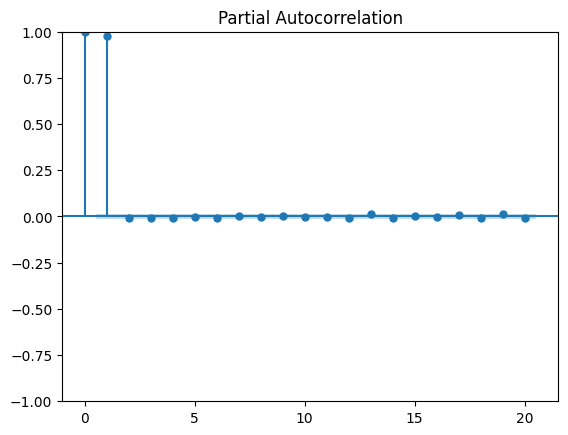

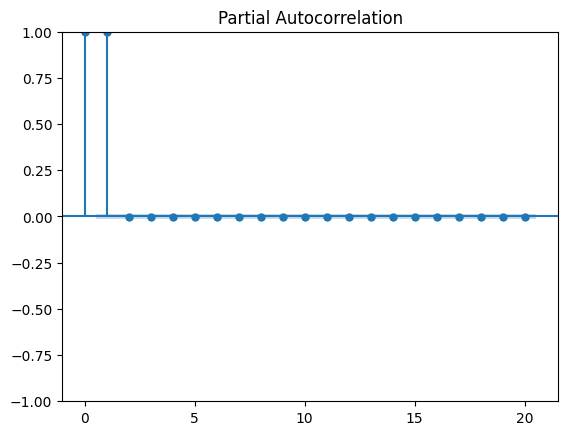

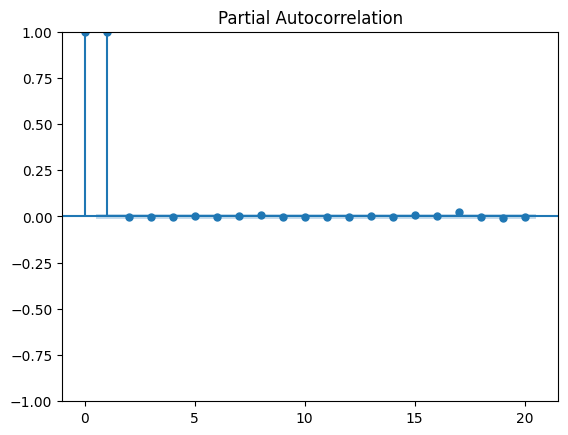

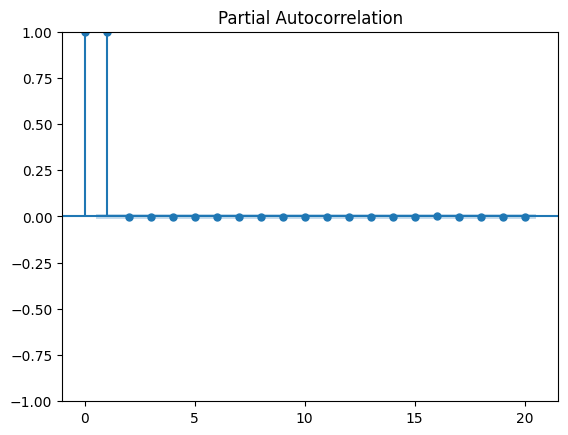

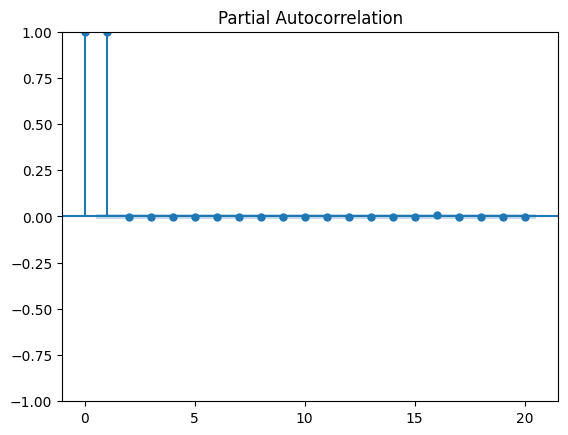

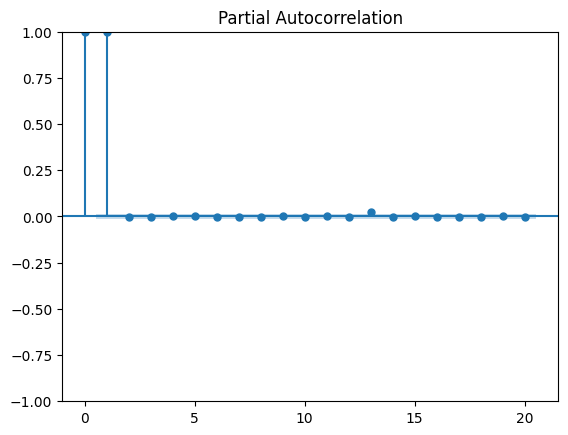

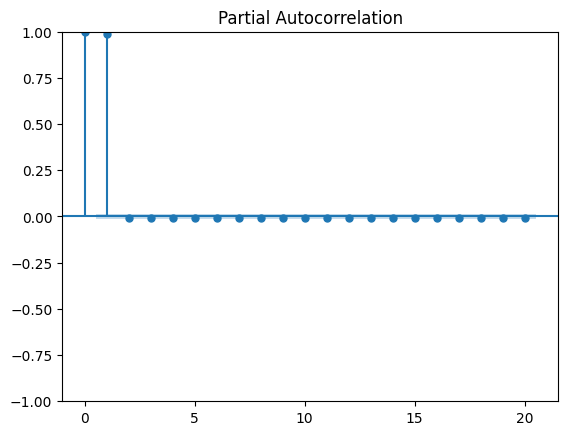

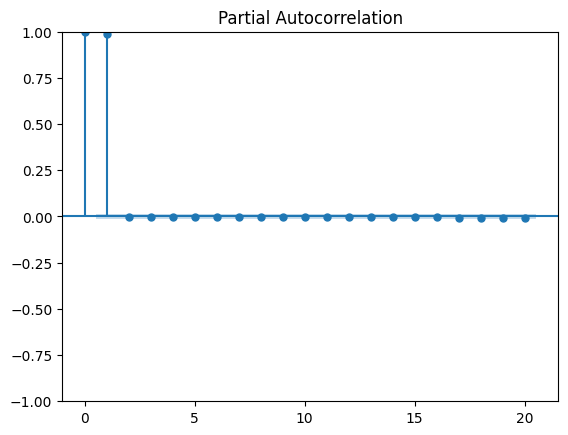

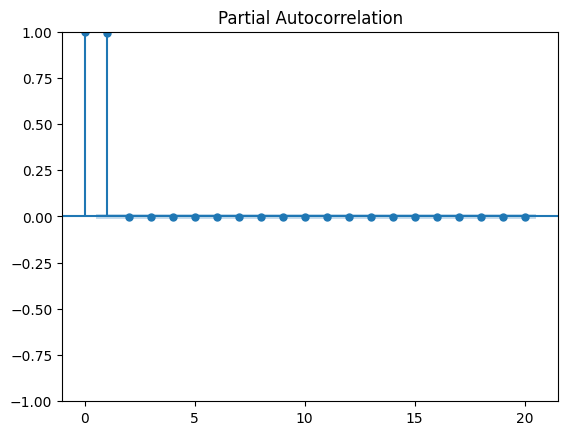

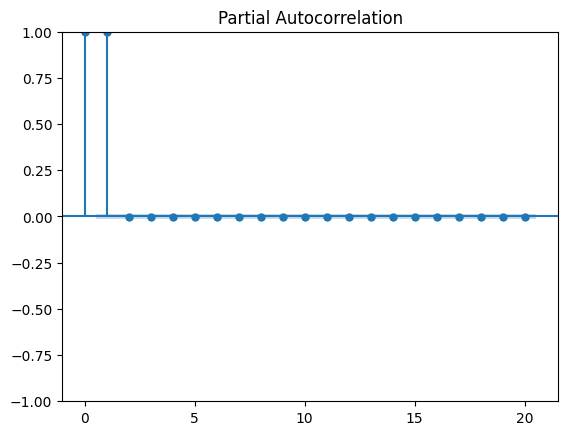

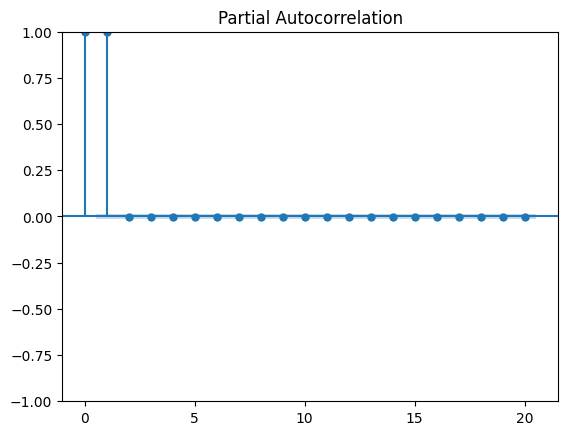

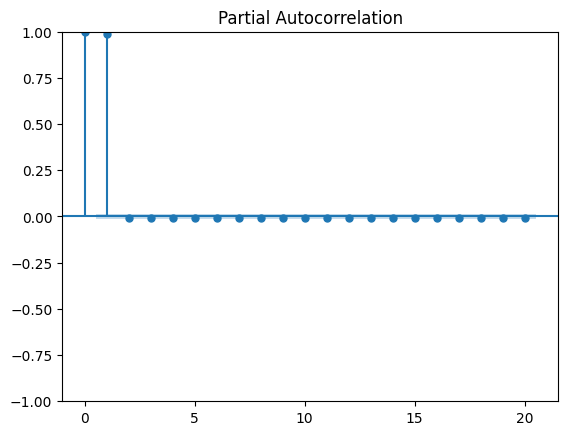

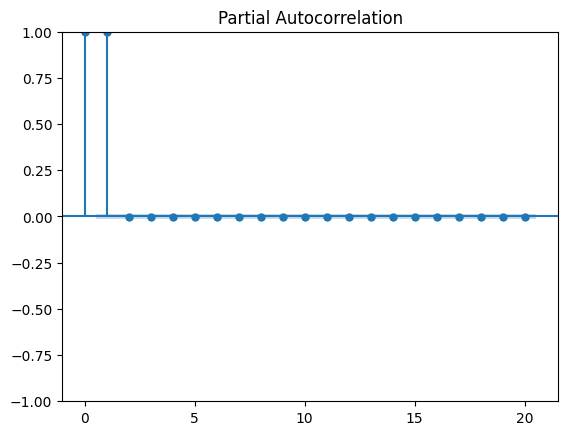

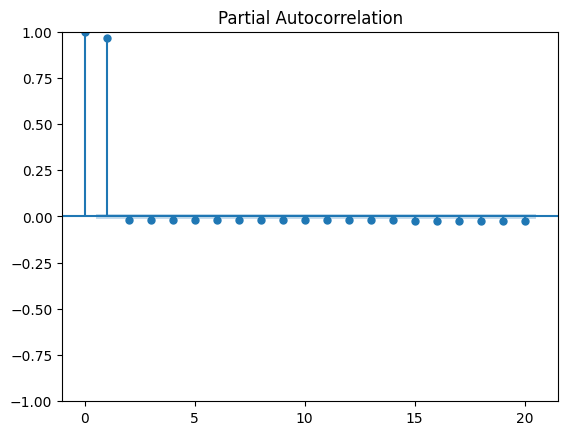

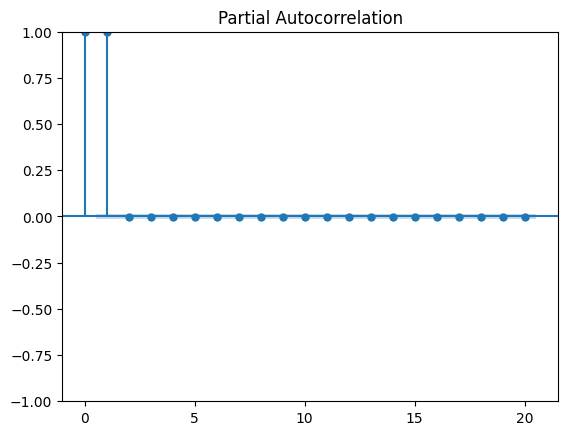

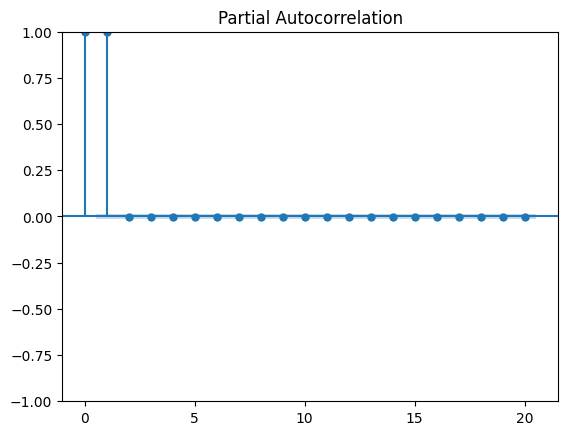

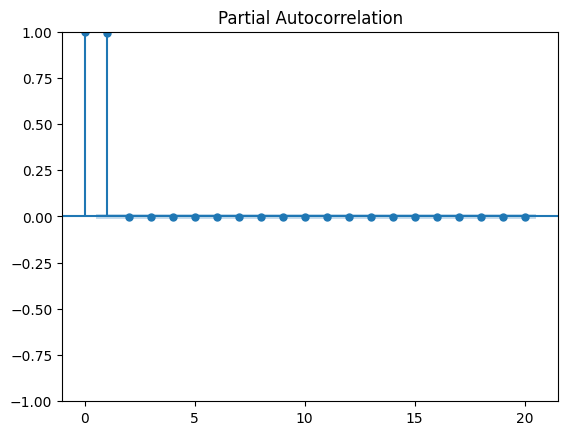

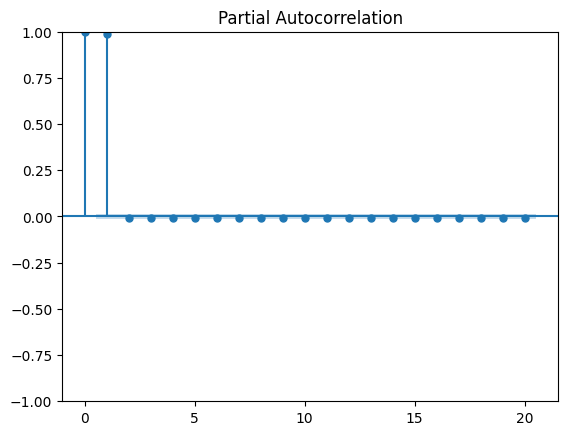

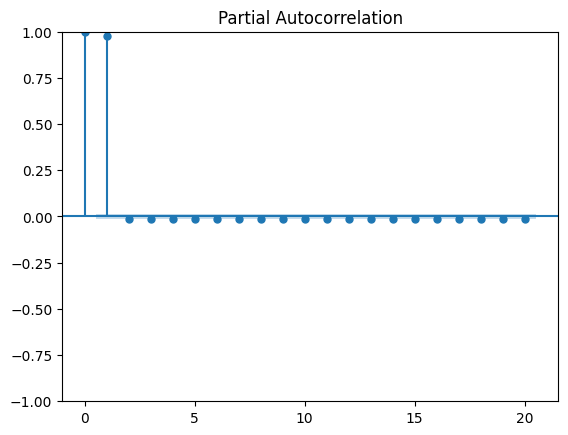

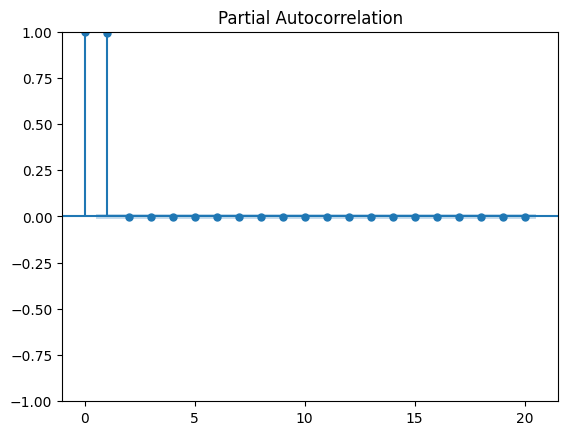

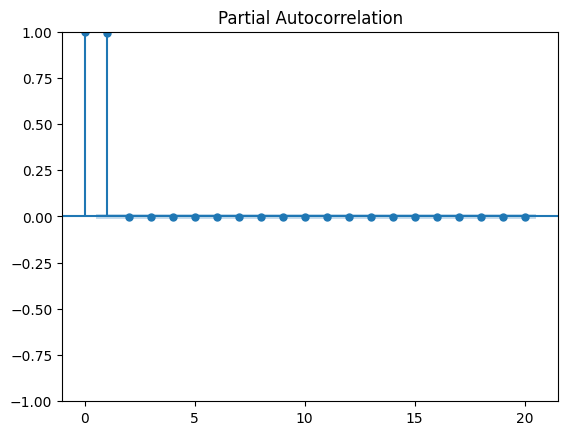

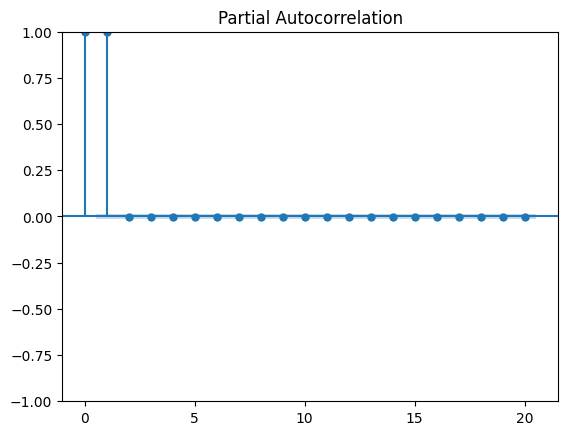

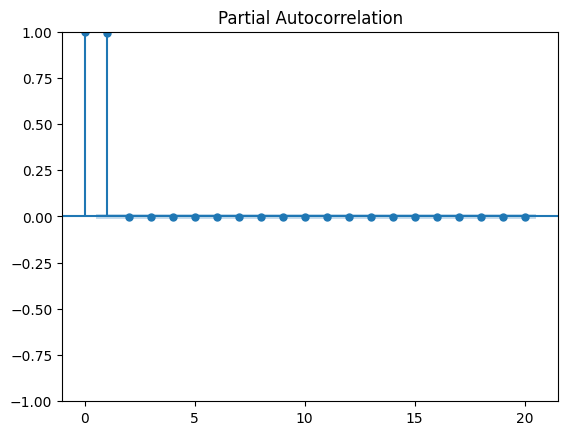

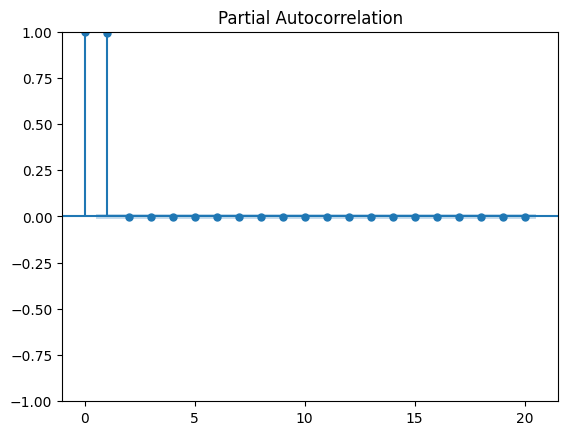

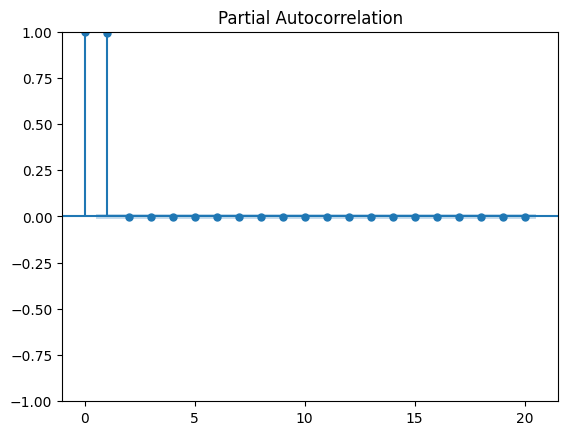

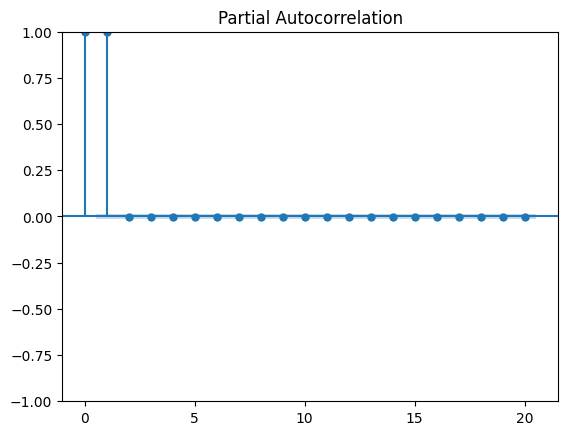

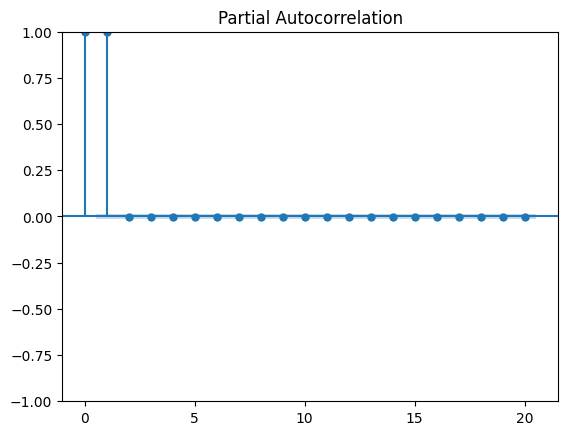

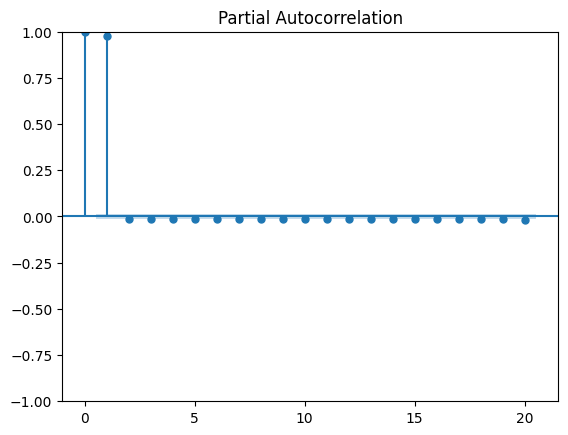

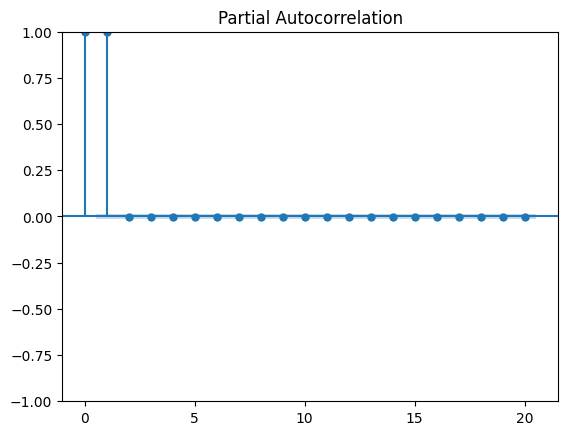

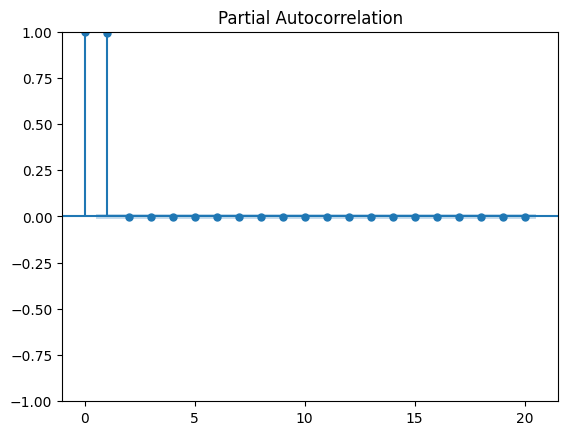

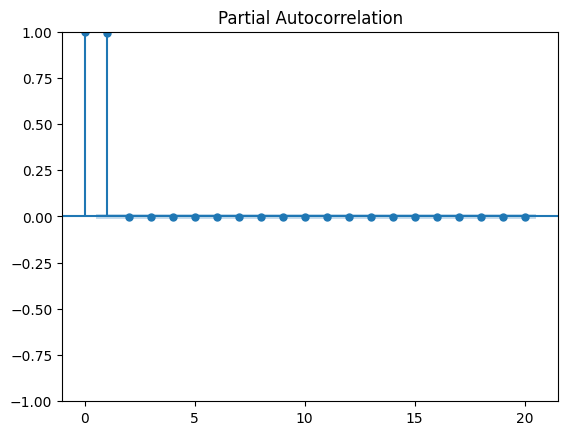

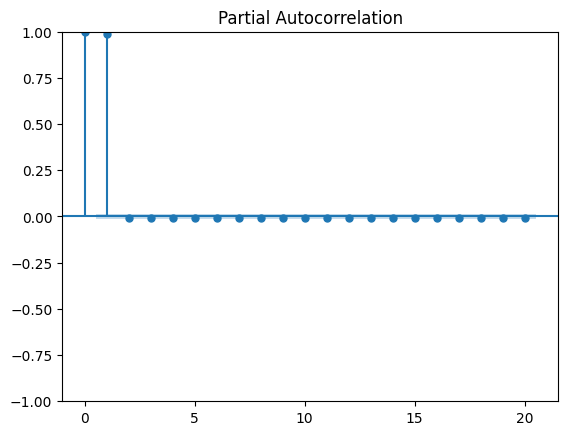

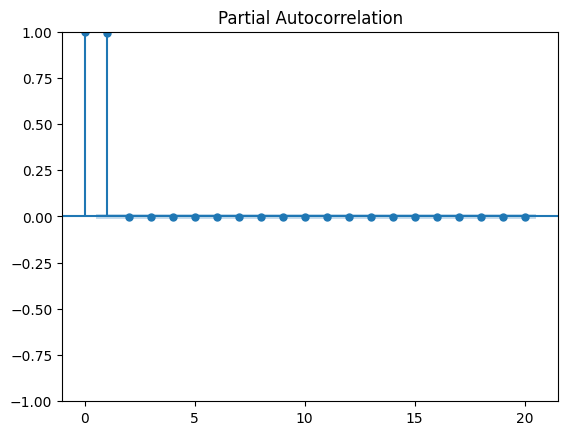

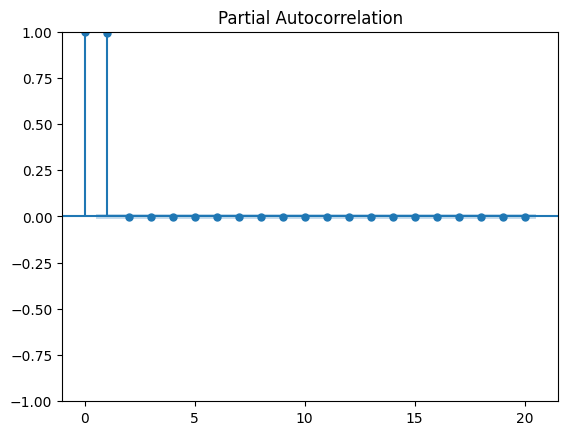

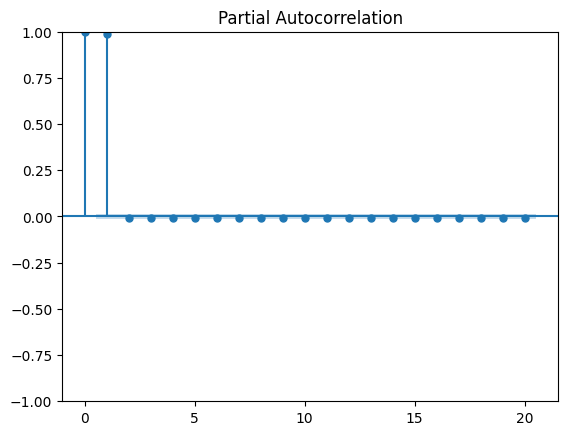

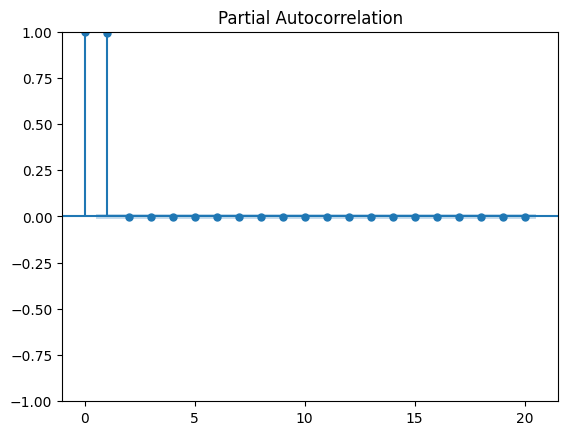

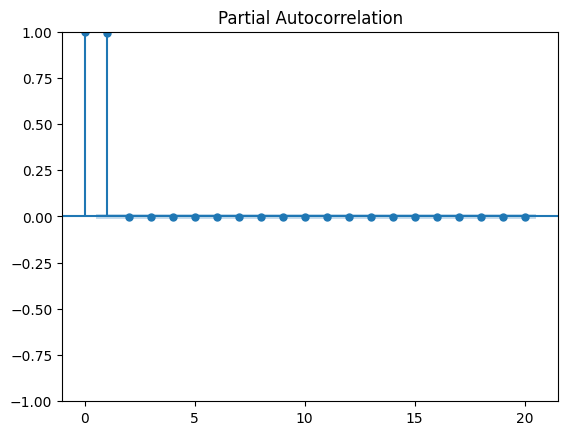

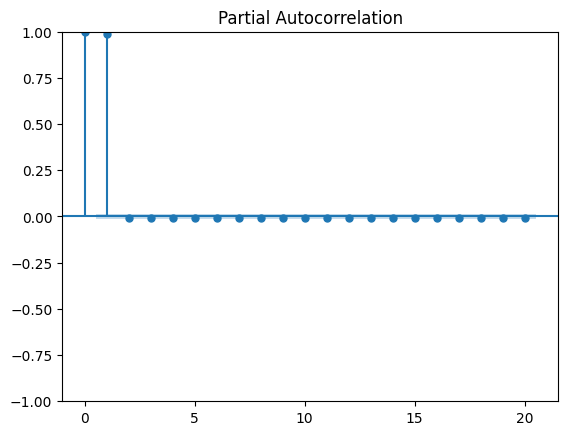

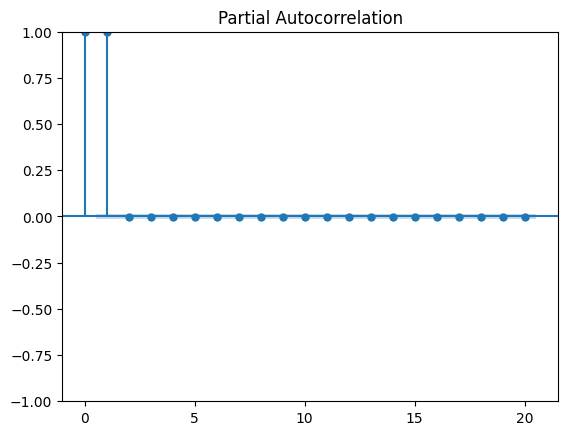

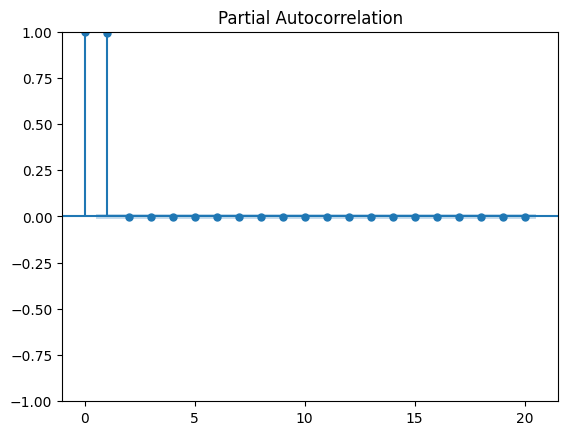

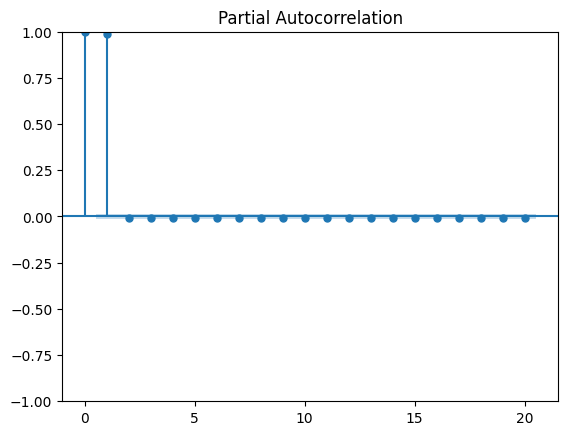

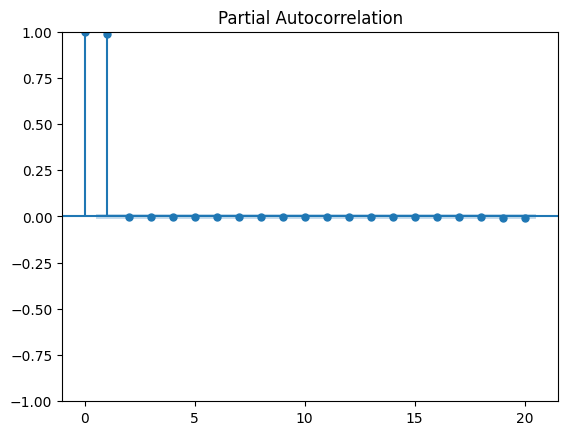

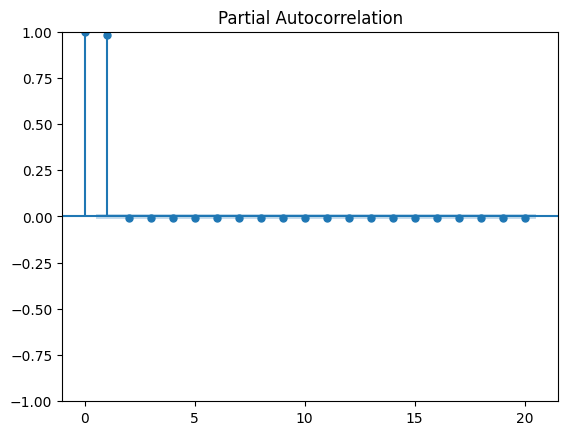

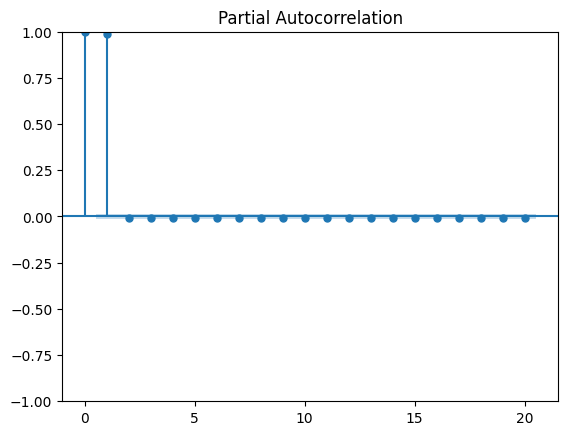

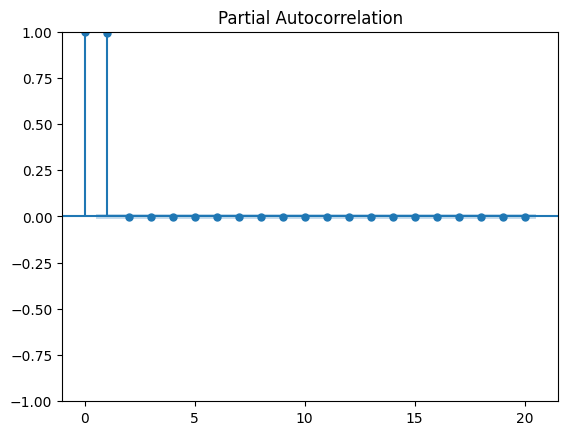

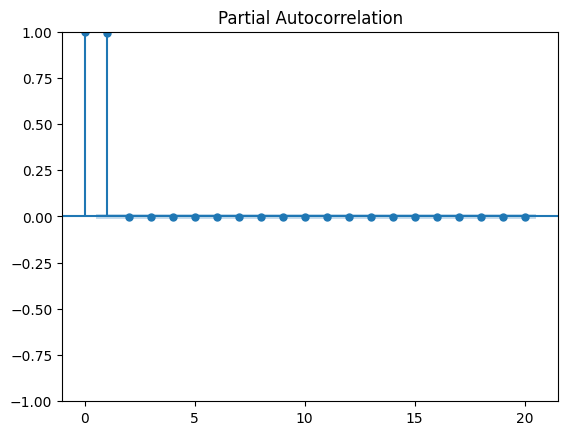

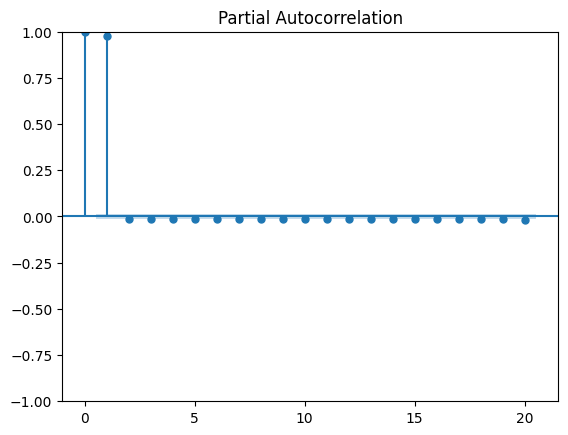

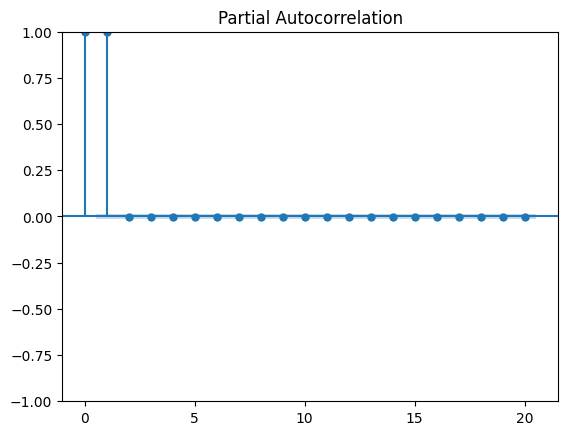

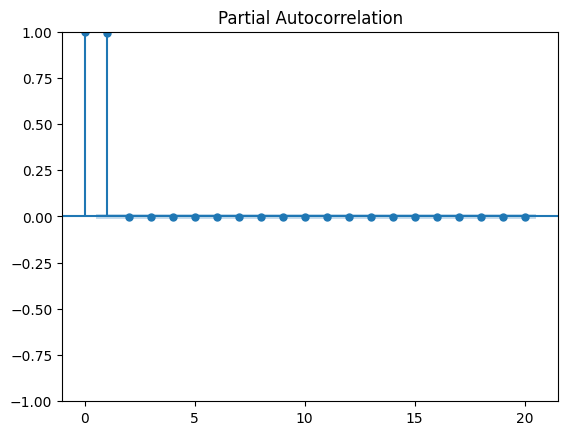

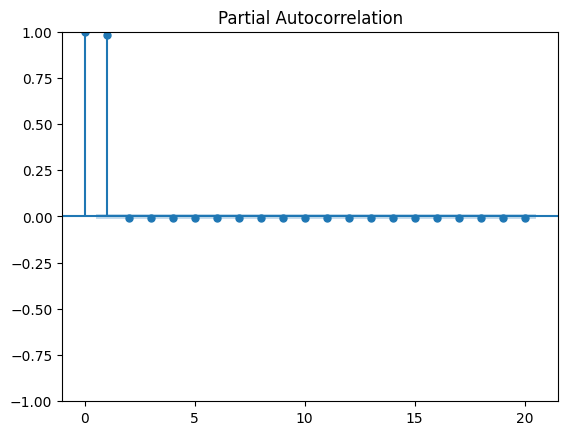

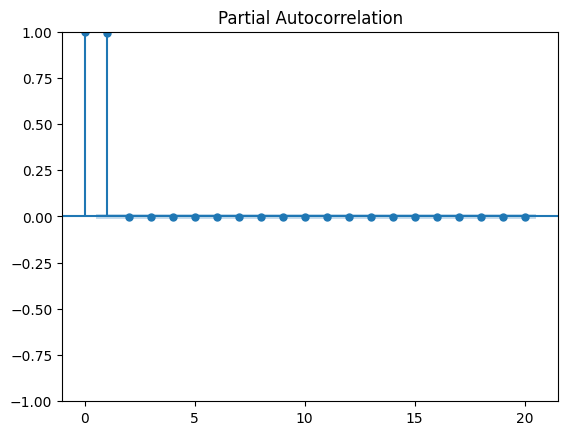

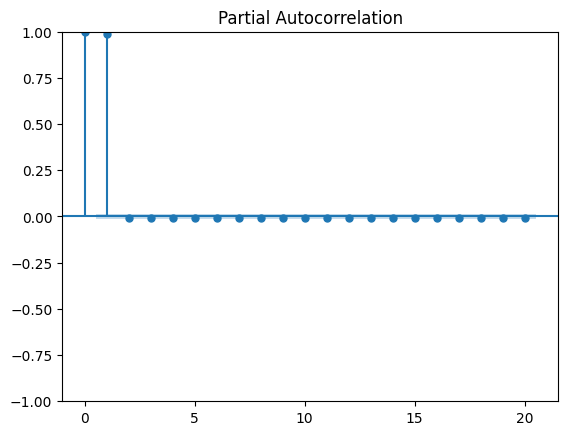

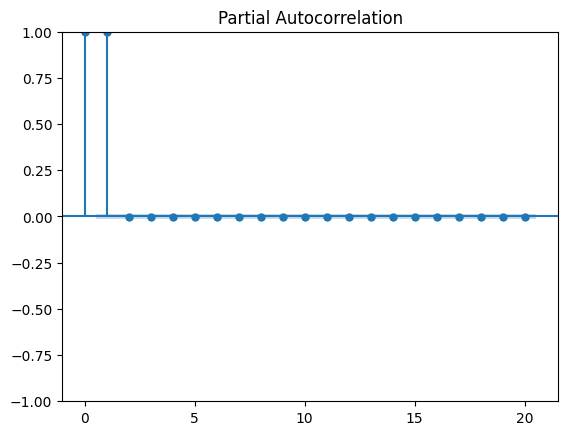

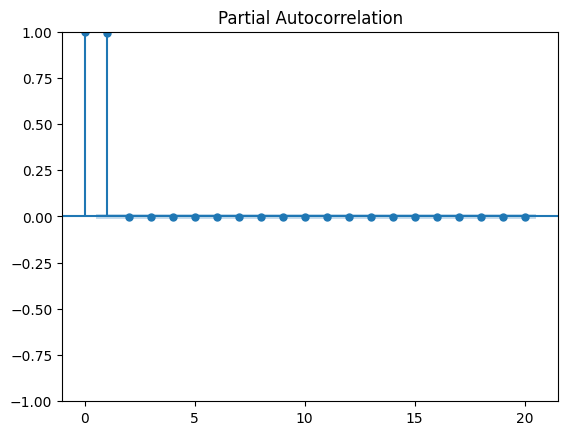

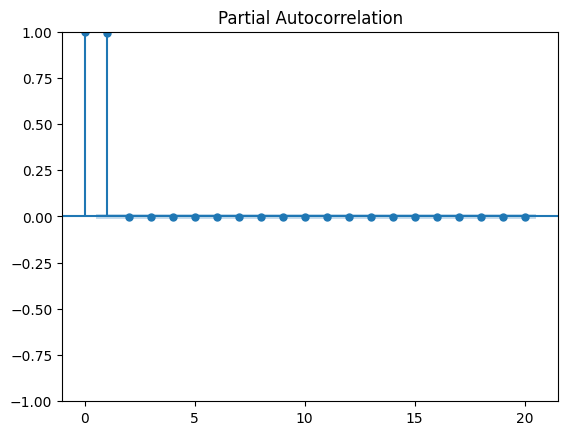

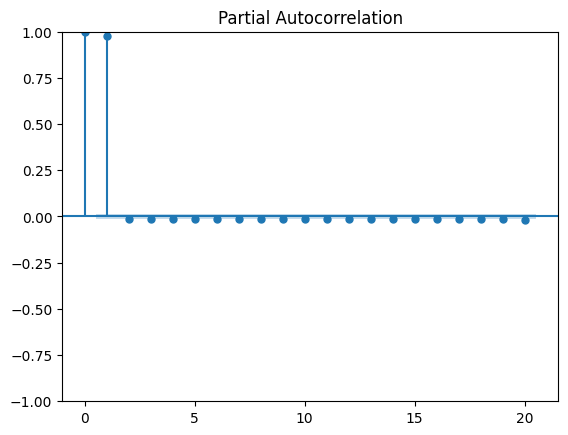

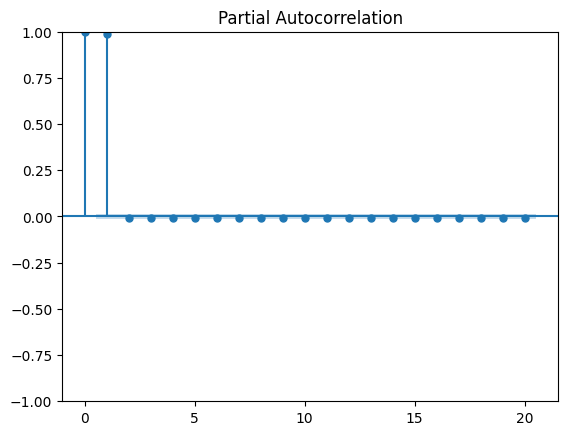

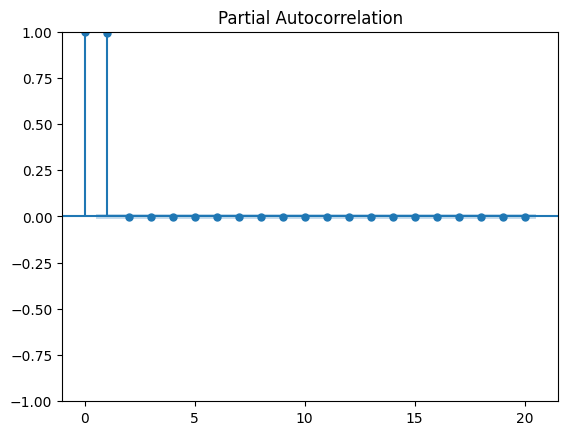

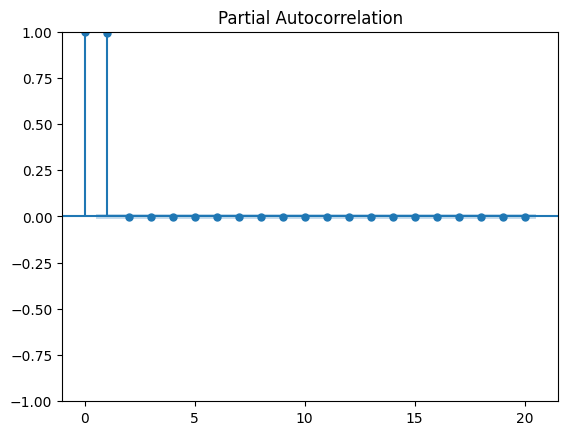

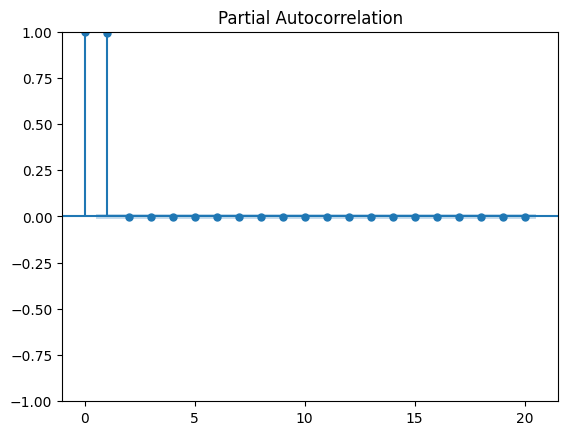

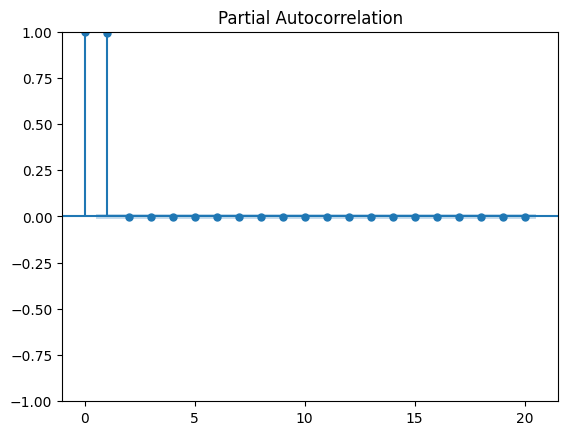

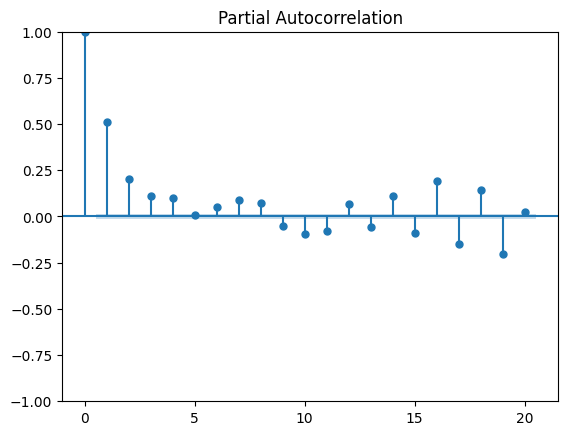

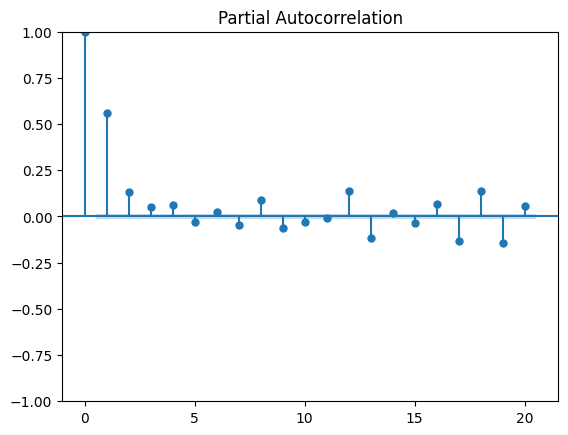

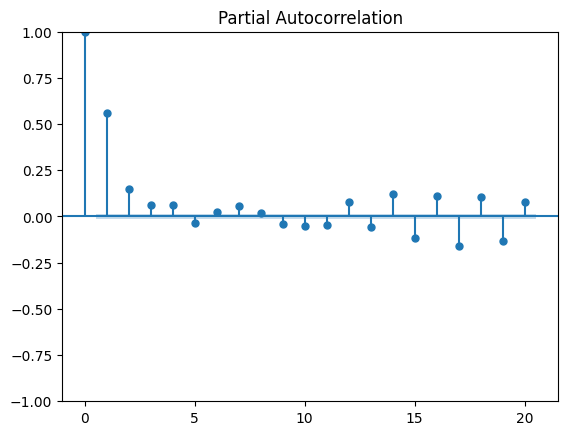

In [30]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

# Calculate the residuals
residuals1 = model1.resid

# Check for autocorrelation in the residuals
dw = sm.stats.stattools.durbin_watson(residuals1)
if dw < 1.5 or dw > 2.5:
    for col in reduced_X.columns:
        pacf_vals = sm.tsa.stattools.pacf(reduced_X[col])
        if max(abs(pacf_vals[1:])) > 0.5: # check for significant autocorrelation
            plot_pacf(reduced_X[col], lags=20)

In [31]:
model2 = sm.OLS(full_reg.y, full_reg.X).fit_regularized() # need to tune the hyperparams

# model_rmse(model2, test_data)
model_rmse(model2, val_data)

(51289.00671045709, 0.784621187394035)

In [32]:
# Regularised Regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

alpha_values = [.0001, .001, .005, .01, .05, 0.1, 0.5, 1.0, 5.0] # list of alpha values to try
rmse_scores = []
r2_scores = []
mse_scores = []
mae_scores = []

# tracking best alpha vlue and corresponding scores
best_alpha = None
best_rmse_score = float('inf')
best_r2_score = 0
best_mse_score = 0
best_mae_score = 0

# tracking worst alpha vlue and corresponding scores
worst_alpha = None
worst_rmse_score = 0
worst_r2_score = 1
worst_mse_score = float('inf')
worst_mae_score = float('inf')


# tracking the actual and predicted y values at the best alpha and RMSE
best_y_values = []
best_y_predicted = []

# tracking the actual and predicted y values at the worst alpha and RMSE
worst_y_values = []
worst_y_predicted = []

for alpha in alpha_values:

    model = sm.OLS(full_reg.y, full_reg.X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0.1)
    frval_data = add_onehot(val_data,"Area")
    frval_data = add_onehot(frval_data,"Item")
    y_val = frval_data['hg/ha_yield']

    frval_data = frval_data.drop('hg/ha_yield', axis=1)
    frval_data = sm.add_constant(frval_data, has_constant='add')
    y_pred = model.predict(frval_data)


    # evaluate RMSE
    rmse_score = rmse(y_val, y_pred)
    rmse_scores.append(rmse_score)

    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)

    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)
    
    print(f"Alpha={alpha}, RMSE Score={rmse_score}, R2={r2}, MSE={mse}, MAE={mae}")


    if rmse_score < best_rmse_score:  # update best alpha if current score is better
        best_alpha = alpha
        best_rmse_score = rmse_score
        best_r2_score = r2
        best_mse_score = mse
        best_mae_score = mae

        best_y_values = y_val
        best_y_predicted = y_pred

    if rmse_score > worst_rmse_score:    # update worst alpha if current score is worse
        worst_alpha = alpha
        worst_rmse_score = rmse_score
        worst_r2_score = r2
        worst_mse_score = mse
        worst_mae_score = mae

        worst_y_values = y_val
        worst_y_predicted = y_pred

print(f"Best Alpha={best_alpha}, Best RMSE Score={best_rmse_score}, Best R2={r2}, Best MSE={mse}, Best MAE={mae}")

Alpha=0.0001, RMSE Score=51292.241052678604, R2=0.7146648063100429, MSE=2630893992.2060885, MAE=33477.2403797489
Alpha=0.001, RMSE Score=51476.48648902692, R2=0.7126112353655186, MSE=2649828661.2549706, MAE=33045.6422908159
Alpha=0.005, RMSE Score=52537.97292655065, R2=0.700636658992998, MSE=2760238599.2309685, MAE=33093.792326231094
Alpha=0.01, RMSE Score=53717.59136687071, R2=0.6870427227915796, MSE=2885579622.258102, MAE=33744.71970153105
Alpha=0.05, RMSE Score=60468.41499544143, R2=0.6034397659017137, MSE=3656429212.060926, MAE=39223.610890006225
Alpha=0.1, RMSE Score=66234.99393198873, R2=0.5241971993530221, MSE=4387074421.170585, MAE=44863.86858277232
Alpha=0.5, RMSE Score=82343.52756742299, R2=0.26462149989072414, MSE=6780456532.24695, MAE=60622.281356475774
Alpha=1.0, RMSE Score=87124.97488386281, R2=0.17673941347872457, MSE=7590761248.513725, MAE=65147.11490279548
Alpha=5.0, RMSE Score=92117.04642388967, R2=0.07969453387325276, MSE=8485550241.861044, MAE=69769.26370056935
Best

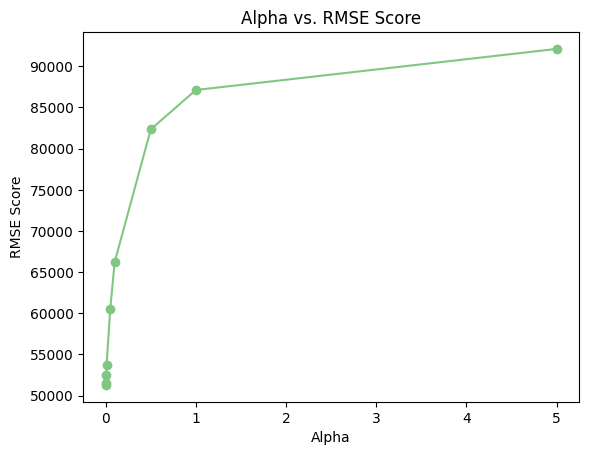

In [33]:
plt.plot(alpha_values, rmse_scores, marker='o', color= '#81C784')
plt.xlabel('Alpha')
plt.ylabel('RMSE Score')
plt.title('Alpha vs. RMSE Score')
plt.show()

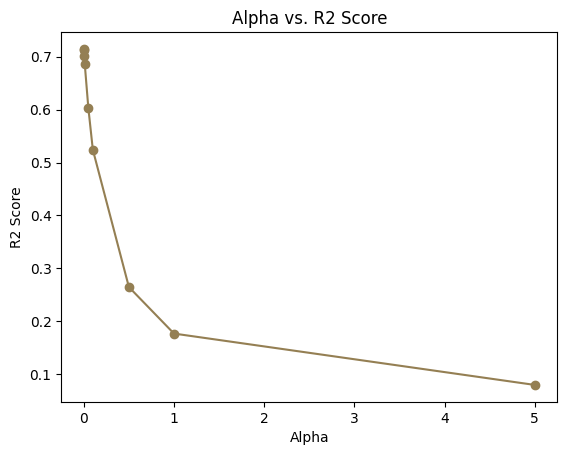

In [34]:
plt.plot(alpha_values, r2_scores, marker='o', color= '#947F53')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.title('Alpha vs. R2 Score')
plt.show()

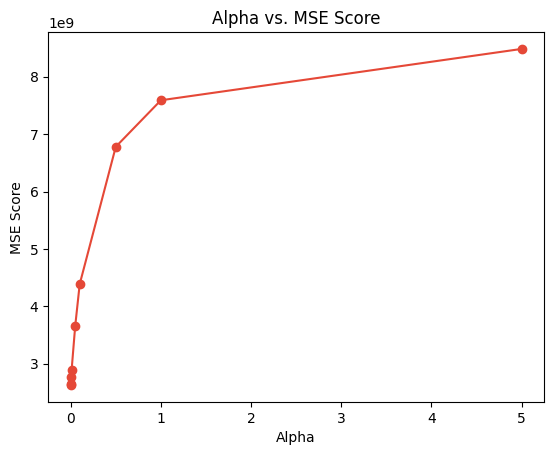

In [35]:
plt.plot(alpha_values, mse_scores, marker='o', color= '#E54837')
plt.xlabel('Alpha')
plt.ylabel('MSE Score')
plt.title('Alpha vs. MSE Score')
plt.show()

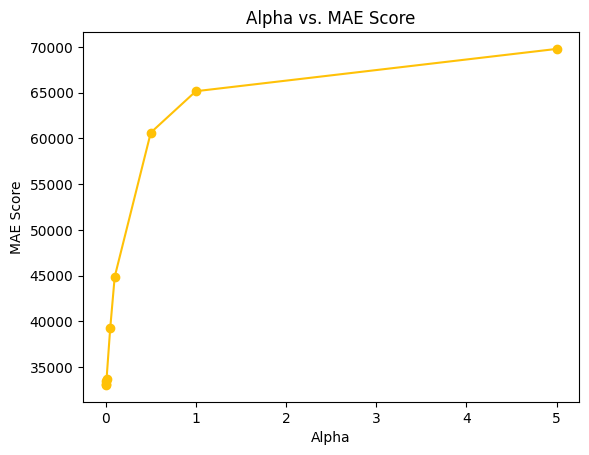

In [36]:
plt.plot(alpha_values, mae_scores, marker='o', color= '#FFC107')
plt.xlabel('Alpha')
plt.ylabel('MAE Score')
plt.title('Alpha vs. MAE Score')
plt.show()

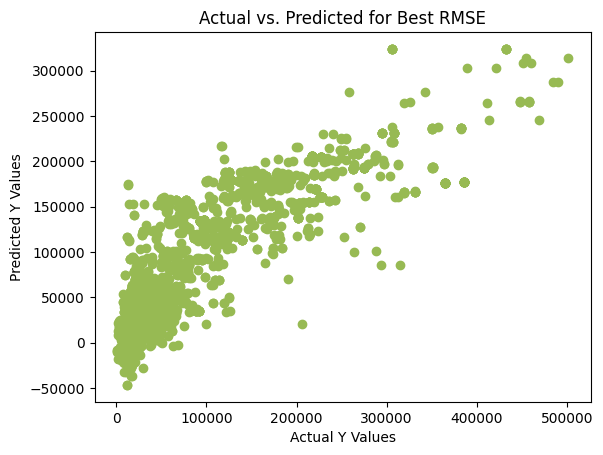

In [37]:
plt.plot(best_y_values, best_y_predicted, marker='o', linestyle='none', color= '#97BA53')
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')
plt.title('Actual vs. Predicted for Best RMSE')
plt.show()

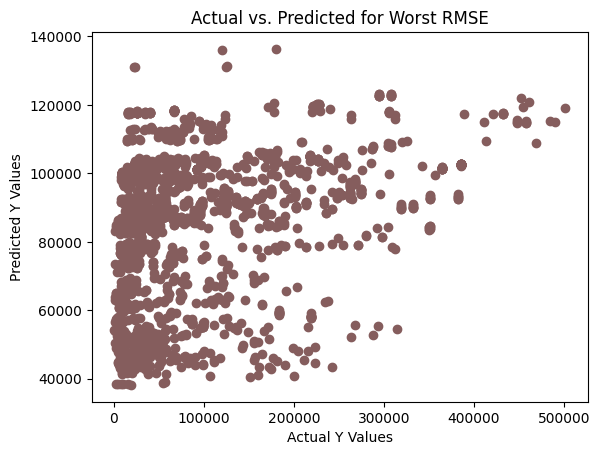

In [38]:
plt.plot(worst_y_values, worst_y_predicted, marker='o', linestyle='none', color= '#855D5D')
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')
plt.title('Actual vs. Predicted for Worst RMSE')
plt.show()

In [39]:
# RF model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

frtest_data = add_onehot(val_data,"Area")
frtest_data = add_onehot(frtest_data,"Item")
y_test = frtest_data['hg/ha_yield']
frtest_data = frtest_data.drop('hg/ha_yield', axis=1)
frtest_data = sm.add_constant(frtest_data, has_constant='add')

min_samples_split = int(0.05*full_reg.X.shape[0])

# create the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=min_samples_split)

# fit the model on the training data
rf.fit(full_reg.X, full_reg.y)

# make predictions on the test data
y_pred = rf.predict(frtest_data)

# qwe = rmse(y_test, y_pred)
# print(qwe)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

RMSE: 51026.082041669106
R-squared: 0.7176183716317699
MAPE: 0.47790838579940936


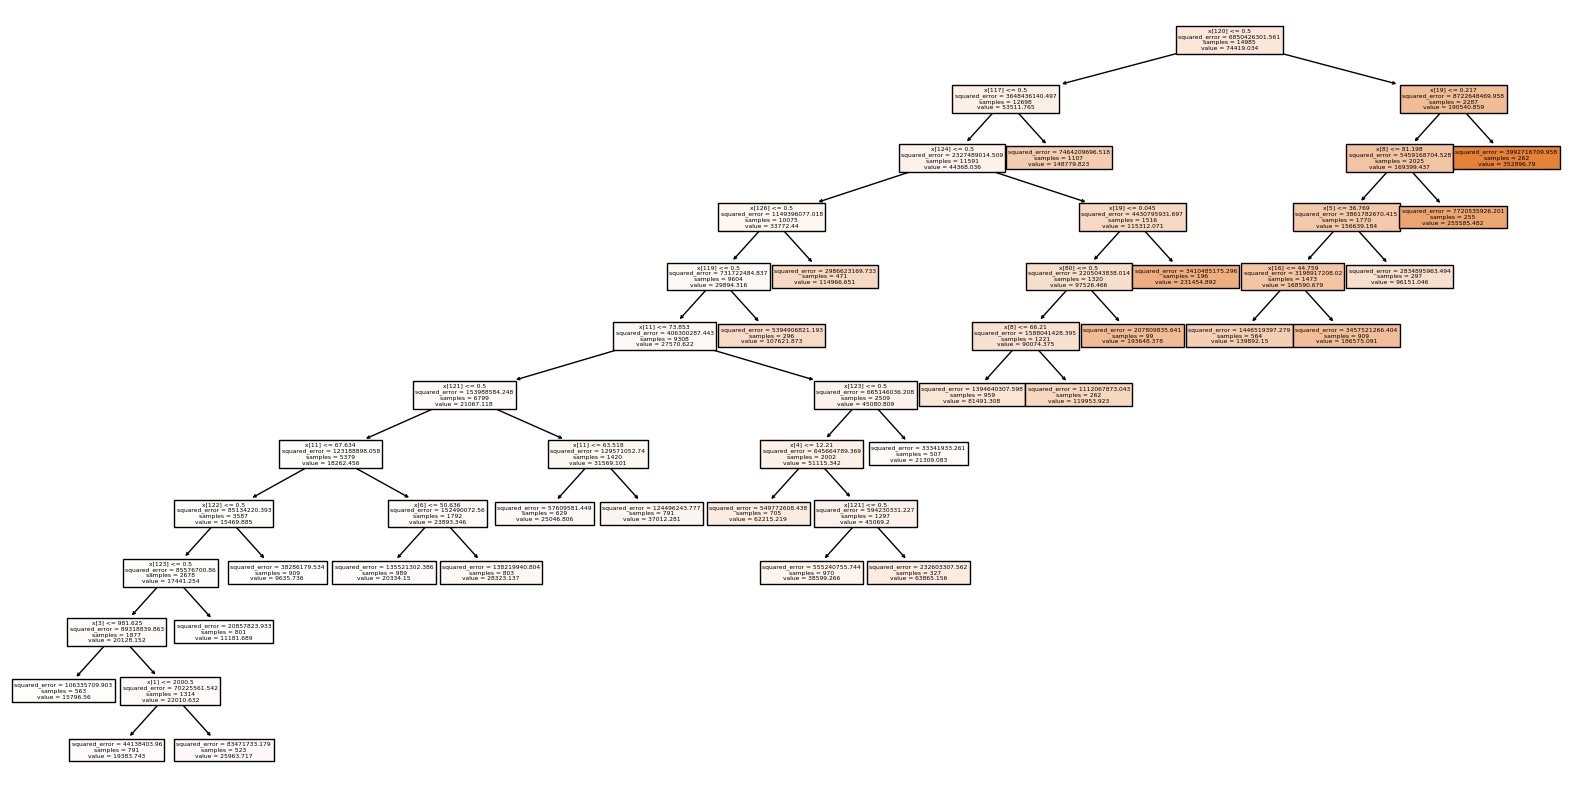

In [40]:
from sklearn.datasets import make_regression
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# plot the first decision tree in the random forest
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True)
plt.show()

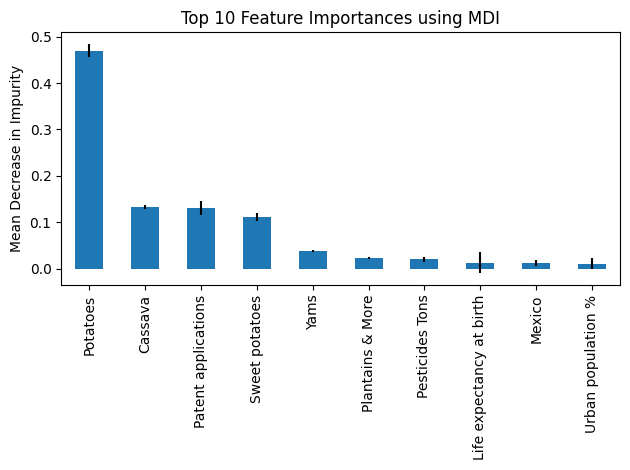

In [41]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=full_reg.X.columns.values.tolist())
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Sort the feature importances in descending order and select the top 10
top_10_indices = forest_importances.sort_values(ascending=False).head(10).index
top_10_forest_importances = forest_importances[top_10_indices]
top_10_std = std[sorted(range(len(list(forest_importances))), key=lambda i: list(forest_importances)[i])[-10:]]

# Plot the top 10 feature importances
fig, ax = plt.subplots()
top_10_forest_importances.plot.bar(yerr=top_10_std, ax=ax)
ax.set_title("Top 10 Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xticklabels(['Potatoes', 'Cassava', 'Patent applications',
       'Sweet potatoes', 'Yams', 'Plantains & More', 'Pesticides Tons',
       'Life expectancy at birth', 'Mexico',
       'Urban population %'], rotation=90) # set custom x-axis labels
fig.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# calculate and print the metrics
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Absolute percentage Error:", mae)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
rfscore = rf.score(frtest_data, y_test)
print('RF score:', rfscore )

Mean Absolute Error: 28355.289504544682
Mean Absolute percentage Error: 28355.289504544682
Mean Squared Error: 2603661048.523146
Root Mean Squared Error: 51026.082041669106
R-squared: 0.7176183716317699
RF score: 0.7176183716317699


## Test Specific Crop or Area

In [43]:
def testitem(df,item):
    item_df = df.copy()
    item_df = df[df["Item"] == item]
    item_df = item_df.drop('Item', axis=1)
    item_df = add_onehot(item_df,"Area")
    item_reg = MLR(item_df,0.05)
    item_reg.printall()


def testarea(df,area):
    area_df = df.copy()
    area_df = df[df["Area"] == area]
    area_df = area_df.drop('Area', axis=1)
    area_df = add_onehot(area_df,"Item")
    area_df = MLR(area_df,0.05)
    area_df.printall()

def testallitems(df):
    for item in list(df.Item.unique()):
        testitem(df,item)

def testallareas(df):
    for area in list(df.Area.unique()):
        testitem(df,area)

testitem(train_data,"Maize")
testarea(train_data,"Argentina")
# testallitems(train_data)
# testallareas(train_data)


__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        
                            OLS Regression Results                            
Dep. Variable:            hg/ha_yield   R-squared:                       0.948
Model:  

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Highest 5 VIF Values:  [inf inf inf inf inf]
Since VIF is too high, multicollinearity is problematic.
__________


AttributeError: ignored